# Cervix EDA

In this competition we have a multi-class classification problem with **three** classes. We are asked, given an image, to identify the cervix type.

From the data description:

*In this competition, you will develop algorithms to correctly classify cervix types based on cervical images. These different types of cervix in our data set are all considered normal (not cancerous), but since the transformation zones aren't always visible, some of the patients require further testing while some don't. This decision is very important for the healthcare provider and critical for the patient. Identifying the transformation zones is not an easy task for the healthcare providers, therefore, an algorithm-aided decision will significantly improve the quality and efficiency of cervical cancer screening for these patients.*

The submission format is asking for a probability for each of the three different cervix types.

In this notebook we will be looking at:

* basic dataset stats like number of samples per class, image sizes
* different embeddings of RGB image space
* pairwise distances and a clustermap of images in RGB space
* (linear) model selection with basic multi class evaluation metrics.

**If you like this kernel, please give an upvote, thanks! :)**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.io import imread, imshow
import cv2

%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

from subprocess import check_output
print(check_output(["ls", "data/train"]).decode("utf8"))

Type_1
Type_2
Type_3



We are given training images for each of cervix types. Lets first count them for each class.

In [2]:
from glob import glob
basepath = 'data/train/'

all_cervix_images = []

for path in sorted(glob(basepath + "*")):
    cervix_type = path.split("/")[-1]
    cervix_images = sorted(glob(basepath + cervix_type + "/*"))
    all_cervix_images = all_cervix_images + cervix_images

all_cervix_images = pd.DataFrame({'imagepath': all_cervix_images})
all_cervix_images['filetype'] = all_cervix_images.apply(lambda row: row.imagepath.split(".")[-1], axis=1)
all_cervix_images['type'] = all_cervix_images.apply(lambda row: row.imagepath.split("/")[-2], axis=1)
all_cervix_images.head()

,imagepath,filetype,type
0,data/train/Type_1/10.jpg,jpg,Type_1
1,data/train/Type_1/1033.jpg,jpg,Type_1
2,data/train/Type_1/104.jpg,jpg,Type_1
3,data/train/Type_1/1040.jpg,jpg,Type_1
4,data/train/Type_1/1056.jpg,jpg,Type_1


## Image types

Now that we have the data in a handy dataframe we can do a few aggregations on the data. Let us first see how many images there are for each cervix type and which file types they have.

All files are in JPG format and Type 2 is the most common one with a little bit more than 50% in the training data in total, Type 1 on the other hand has a little bit less than 20% in the training data.

We have a total of 1470 images in the whole dataset


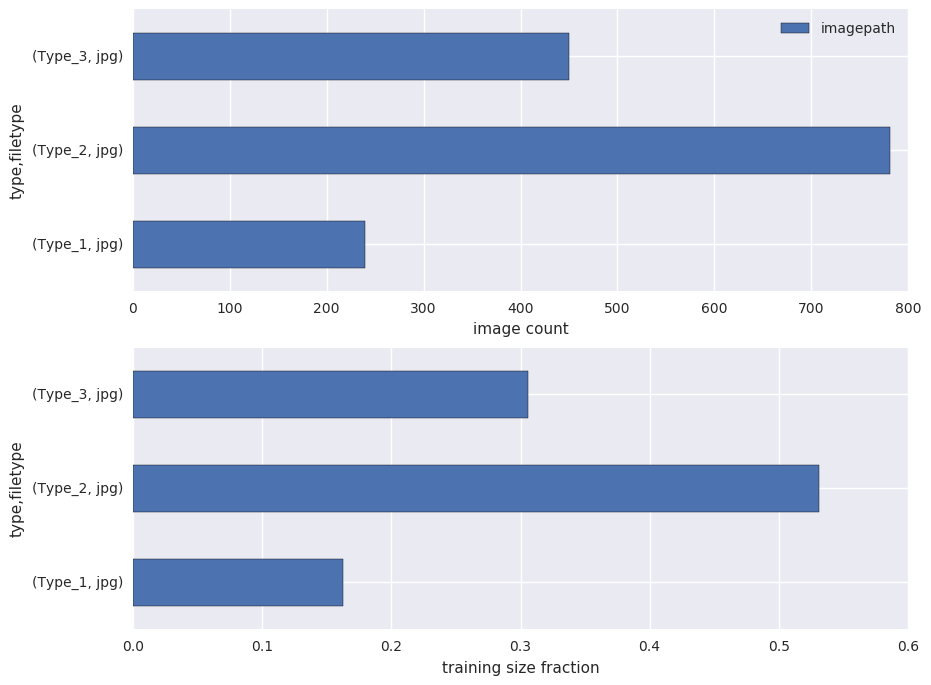

In [3]:
print('We have a total of {} images in the whole dataset'.format(all_cervix_images.shape[0]))
type_aggregation = all_cervix_images.groupby(['type', 'filetype']).agg('count')
type_aggregation_p = type_aggregation.apply(lambda row: 1.0*row['imagepath']/all_cervix_images.shape[0], axis=1)

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

type_aggregation.plot.barh(ax=axes[0])
axes[0].set_xlabel("image count")
type_aggregation_p.plot.barh(ax=axes[1])
axes[1].set_xlabel("training size fraction")

Now, lets read the files for each type to get an idea about how the images look like.

The images seem to vary alot in they formats, the first two samples have only a circular area with the actual image, the last sample has the image in a rectangle.

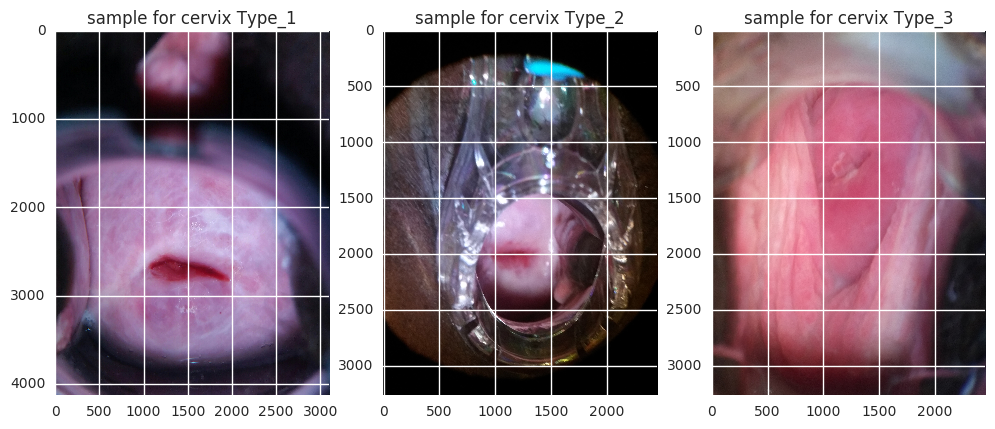

In [4]:
fig = plt.figure(figsize=(12,8))

i = 1
for t in all_cervix_images['type'].unique():
    ax = fig.add_subplot(1,3,i)
    i+=1
    f = all_cervix_images[all_cervix_images['type'] == t]['imagepath'].values[0]
    plt.imshow(plt.imread(f))
    plt.title('sample for cervix {}'.format(t))

## Image dimensions

Now, in order to get an idea of how many different shapes of images by class there are, lets have a look at. To reduce runtime, take only a subsample per class.

In [5]:
from collections import defaultdict

images = defaultdict(list)

for t in all_cervix_images['type'].unique():
    sample_counter = 0
    for _, row in all_cervix_images[all_cervix_images['type'] == t].iterrows():
        #print('reading image {}'.format(row.imagepath))
        try:
            img = imread(row.imagepath)
            sample_counter +=1
            images[t].append(img)
        except:
            print('image read failed for {}'.format(row.imagepath))
        if sample_counter > 35:
            break

In [6]:
dfs = []
for t in all_cervix_images['type'].unique():
    t_ = pd.DataFrame(
        {
            'nrows': list(map(lambda i: i.shape[0], images[t])),
            'ncols': list(map(lambda i: i.shape[1], images[t])),
            'nchans': list(map(lambda i: i.shape[2], images[t])),
            'type': t
        }
    )
    dfs.append(t_)

shapes_df = pd.concat(dfs, axis=0)
shapes_df_grouped = shapes_df.groupby(by=['nchans', 'ncols', 'nrows', 'type']).size().reset_index().sort_values(['type', 0], ascending=False)
shapes_df_grouped

,nchans,ncols,nrows,type,0
2,3,2448,3264,Type_3,28
5,3,3096,4128,Type_3,7
7,3,3264,2448,Type_3,1
4,3,3096,4128,Type_2,18
1,3,2448,3264,Type_2,17
8,3,4128,3096,Type_2,1
3,3,3096,4128,Type_1,21
0,3,2448,3264,Type_1,14
6,3,3120,4160,Type_1,1


All of the images in our sample have three channels, we can ignore this information for now. Now lets build a barplot to get an idea of the distribution of image dimensions by cervix type.

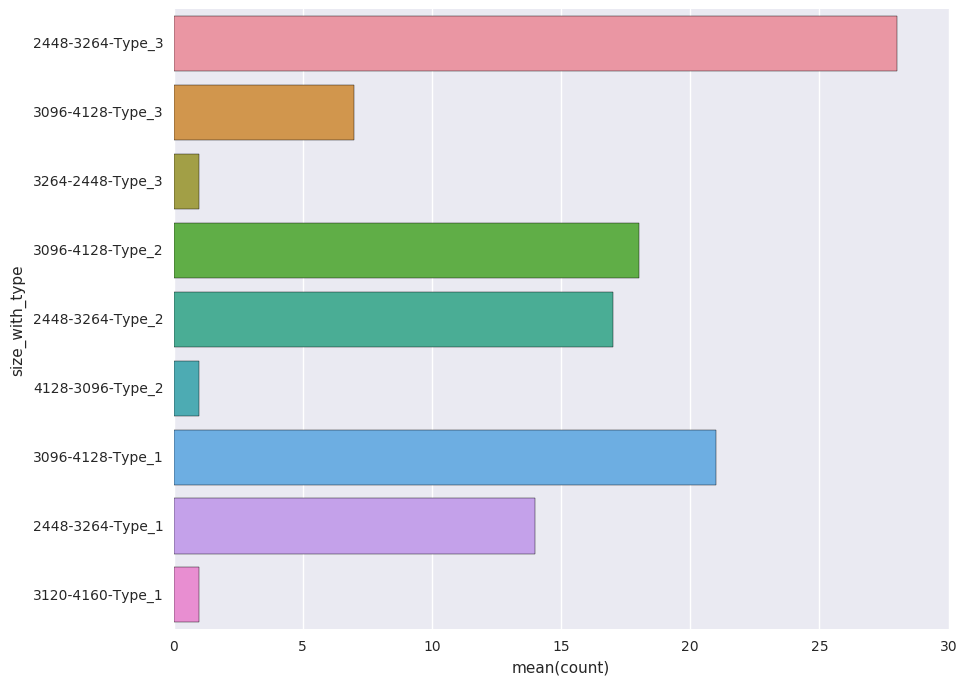

In [7]:
shapes_df_grouped['size_with_type'] = shapes_df_grouped.apply(lambda row: '{}-{}-{}'.format(row.ncols, row.nrows, row.type), axis=1)
shapes_df_grouped = shapes_df_grouped.set_index(shapes_df_grouped['size_with_type'].values)
shapes_df_grouped['count'] = shapes_df_grouped[[0]]

plt.figure(figsize=(10,8))
#shapes_df_grouped['count'].plot.barh(figsize=(10,8))
sns.barplot(x="count", y="size_with_type", data=shapes_df_grouped)

# TSNE embedding

We will now take all of the sample images, rescale them & convert them to grayscale. This will result in a matrix, where each row are all flattened pixel for the grayscale images.

The original images have, as we have seen earlier, quite a high resolution, so scaling them down to **100 x 100** is resulting in a great loss of information, so the embedding to two dimensions is likely not going to have a good structure where we can separate visually by cervical cancer types. Also, we are giving only very few images per class that TSNE can work with to find a good, distance preserving, embedding.

I've added the option to choose to convert them to grayscale before passing them to TSNE. Per default each image will now keep its RGB information and therefore will be transformed to a 100*100*3 = 30.000 dimensional vector.

In [8]:
def transform_image(img, rescaled_dim, to_gray=False):
    resized = cv2.resize(img, (rescaled_dim, rescaled_dim), cv2.INTER_LINEAR)

    if to_gray:
        resized = cv2.cvtColor(resized, cv2.COLOR_RGB2GRAY).astype('float')
    else:
        resized = resized.astype('float')

    normalized = cv2.normalize(resized, None, 0.0, 1.0, cv2.NORM_MINMAX)
    timg = normalized.reshape(1, np.prod(normalized.shape))

    return timg/np.linalg.norm(timg)

rescaled_dim = 100

all_images = []
all_image_types = []

for t in all_cervix_images['type'].unique():
    all_images = all_images + images[t]
    all_image_types = all_image_types + len(images[t])*[t]

# - normalize each uint8 image to the value interval [0, 1] as float image
# - rgb to gray
# - downsample image to rescaled_dim X rescaled_dim
# - L2 norm of each sample = 1
gray_all_images_as_vecs = [transform_image(img, rescaled_dim) for img in all_images]

gray_imgs_mat = np.array(gray_all_images_as_vecs).squeeze()
all_image_types = np.array(all_image_types)
gray_imgs_mat.shape, all_image_types.shape

((108, 30000), (108,))

### 3D t-SNE with cervix indicators

Now let's project the 100x100x3 images to three dimensions to check for low dimensional patterns.

In [9]:
from sklearn.manifold import TSNE
tsne = TSNE(
    n_components=3,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=500,
    verbose=2
).fit_transform(gray_imgs_mat)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 108 / 108
[t-SNE] Mean sigma: 0.219081
[t-SNE] Iteration 25: error = -0.1342997, gradient norm = 0.0008532
[t-SNE] Iteration 25: gradient norm 0.000853. Finished.
[t-SNE] Iteration 50: error = -0.4353501, gradient norm = 0.0004506
[t-SNE] Iteration 50: gradient norm 0.000451. Finished.
[t-SNE] KL divergence after 50 iterations with early exaggeration: -0.435350
[t-SNE] Iteration 75: error = -0.5810226, gradient norm = 0.0003476
[t-SNE] Iteration 75: gradient norm 0.000348. Finished.
[t-SNE] Error after 75 iterations: -0.435350


In [10]:
from sklearn import preprocessing

trace1 = go.Scatter3d(
    x=tsne[:,0],
    y=tsne[:,1],
    z=tsne[:,2],
    mode='markers',
    marker=dict(
        sizemode='diameter',
        color = preprocessing.LabelEncoder().fit_transform(all_image_types),
        colorscale = 'Portland',
        colorbar = dict(title = 'cervix types'),
        line=dict(color='rgb(255, 255, 255)'),
        opacity=0.9
    )
)

data=[trace1]
layout=dict(height=800, width=800, title='3D embedding of images')
fig=dict(data=data, layout=layout)
py.iplot(fig, filename='3DBubble')

We can clearly see that there is a big heterogeneous cluster and a few quite distant outliers.

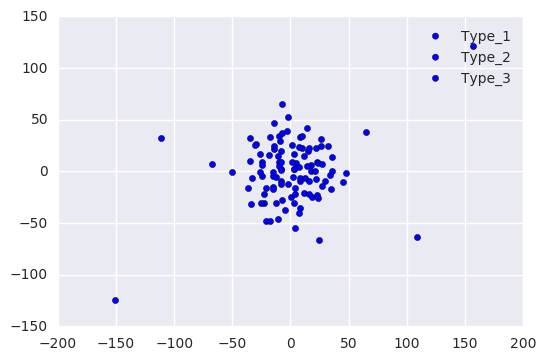

In [11]:
for t in all_cervix_images['type'].unique():
    tsne_t = tsne[np.where(all_image_types == t), :][0]
    plt.scatter(tsne_t[:, 0], tsne_t[:, 1])
plt.legend(all_cervix_images['type'].unique())

# Image clustering with TSNE embedding

Let us now use the compressed images and the distance-preserving transformation of TSNE to get an understanding of what image clusters there are.

For that we will use matplotlib to replace the previously red, green and blue points with the actual images that were input to the TSNE transformation.

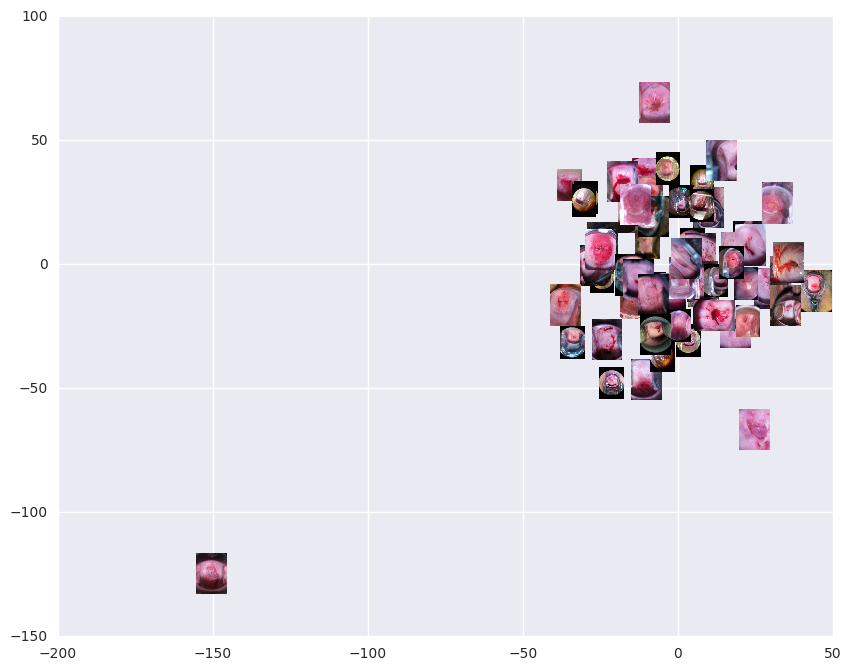

In [12]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
def imscatter(x, y, images, ax=None, zoom=0.01):
    ax = plt.gca()
    images = [OffsetImage(image, zoom=zoom) for image in images]
    artists = []
    for x0, y0, im0 in zip(x, y, images):
        ab = AnnotationBbox(im0, (x0, y0), xycoords='data', frameon=False)
        artists.append(ax.add_artist(ab))
    ax.update_datalim(np.column_stack([x, y]))
    ax.autoscale()
    #return artists

nimgs = 60
plt.figure(figsize=(10,8))
imscatter(tsne[0:nimgs,0], tsne[0:nimgs,1], all_images[0:nimgs])

# Clustering of pairwise image distances

To get a different view of how images relate to each other from a purely numerical point of view, lets now look at pairwise distances. For that we'll use scipy's pdist method.

The yellow somewhat clustered area tells us there are a few images that have relatively high distance to all other images in the sample of our training images we read.
On the left and top of the clustermap we find one of three colors for each row and column, this color indicates the type of cervix.

* Type 1: Red
* Type 2: Green
* Type 3: Blue

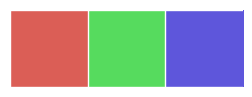

In [14]:
pal = sns.color_palette("hls", 3)
sns.palplot(pal)

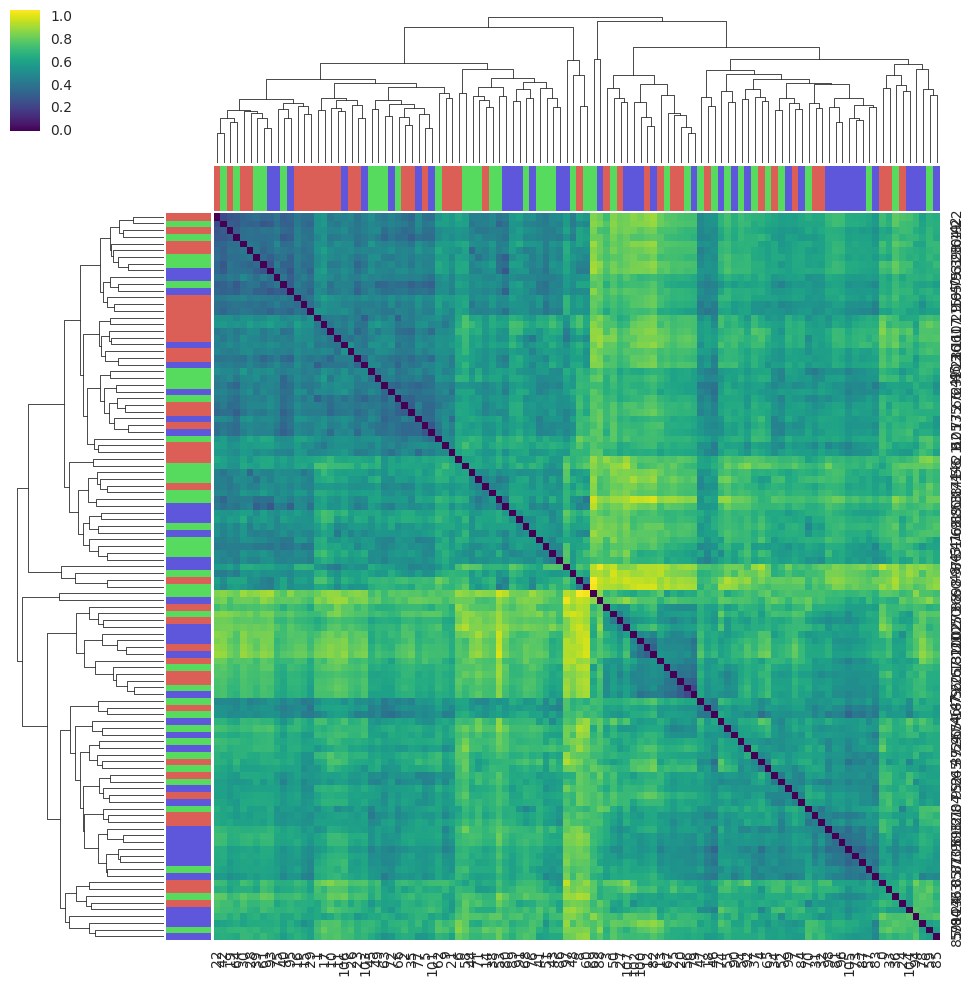

In [15]:
from scipy.spatial.distance import pdist, squareform

sq_dists = squareform(pdist(gray_imgs_mat))

all_image_types = list(all_image_types)

d = {
    'Type_1': pal[0],
    'Type_2': pal[1],
    'Type_3': pal[2]
}

# translate each sample to its color
colors = list(map(lambda t: d[t], all_image_types))

sns.clustermap(
    sq_dists,
    figsize=(12,12),
    row_colors=colors, col_colors=colors,
    cmap=plt.get_cmap('viridis')
)

Here is the unclustered distance matrix.

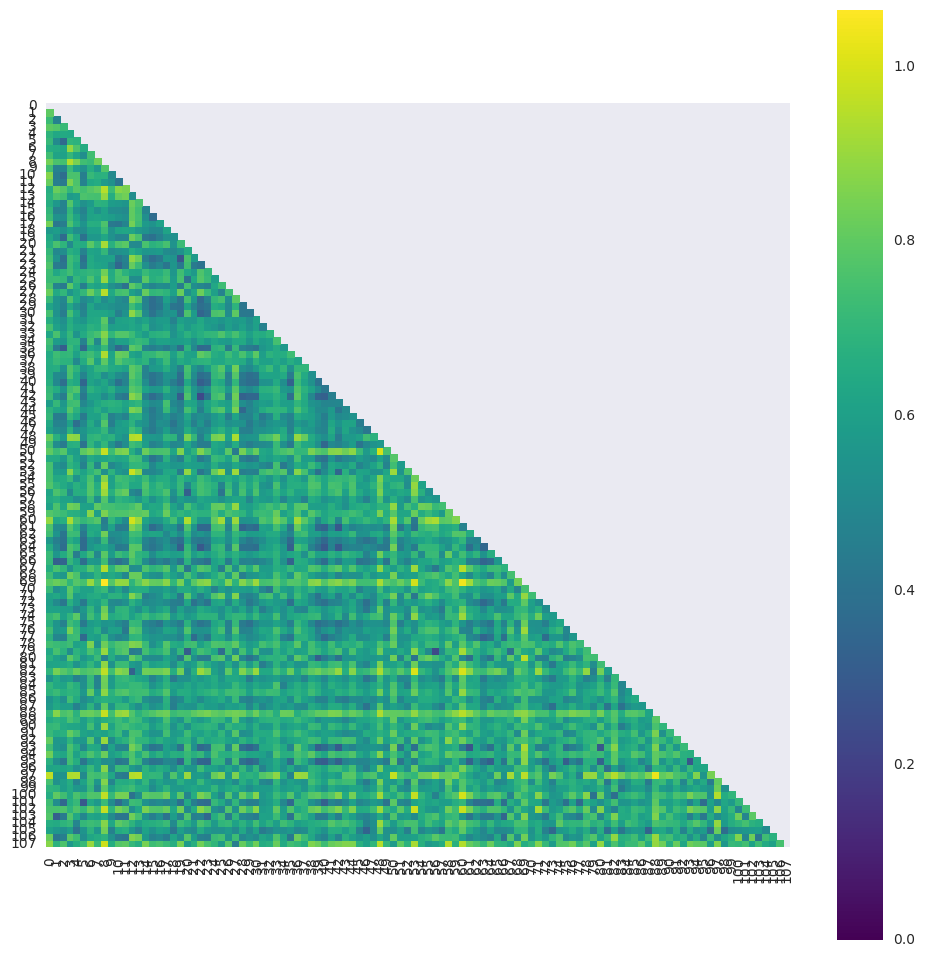

In [16]:

mask = np.zeros_like(sq_dists, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(12,12))
sns.heatmap(sq_dists, cmap=plt.get_cmap('viridis'), square=True, mask=mask)

----------

# Image neighbourhood

Given the pool of cervix images, and the similarity matrix above, we will now plot the extrem cases of the similarity matrix.

To do that we find the image that has:

* maximal distance on average compared to the all other images
* minimal distance on average compared to the all other images

and compare both candidates to the mean image from out set of images.

/home/ubuntu/anaconda2/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning:

Mean of empty slice



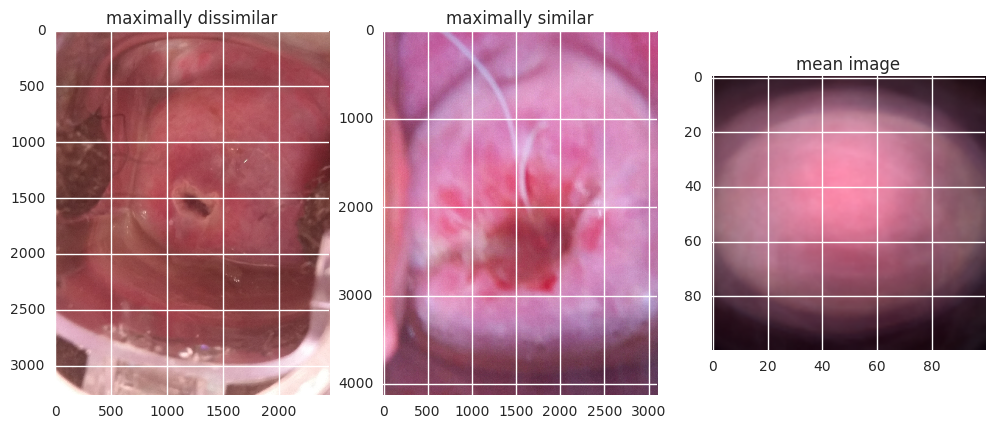

In [17]:
# upper triangle of matrix set to np.nan
sq_dists[np.triu_indices_from(mask)] = np.nan
sq_dists[0, 0] = np.nan

fig = plt.figure(figsize=(12,8))
# maximally dissimilar image
ax = fig.add_subplot(1,3,1)
maximally_dissimilar_image_idx = np.nanargmax(np.nanmean(sq_dists, axis=1))
plt.imshow(all_images[maximally_dissimilar_image_idx])
plt.title('maximally dissimilar')

# maximally similar image
ax = fig.add_subplot(1,3,2)
maximally_similar_image_idx = np.nanargmin(np.nanmean(sq_dists, axis=1))
plt.imshow(all_images[maximally_similar_image_idx])
plt.title('maximally similar')

# now compute the mean image
ax = fig.add_subplot(1,3,3)
mean_img = gray_imgs_mat.mean(axis=0).reshape(rescaled_dim, rescaled_dim, 3)
plt.imshow(cv2.normalize(mean_img, None, 0.0, 1.0, cv2.NORM_MINMAX))
plt.title('mean image')

The image on the left has quite a lot of blue in it which I would not expect to be present in the majority of samples. I think it is a good representation of maximally dissimilar.

----------

# Model Selection

Now that we've established a basic idea about the data, let's do the most straightforward approach, where we take the resized color images and labels and train a, most likely quite heavily regularized, linear model like logistic regression on it.

It is quite important to understand that we only have read a few training instances, 108, and have thousands of dimensions. To be able to cope with that we'll most likely end up using L1 regularization.

For the multi-class problem we are faced with here, we'll use standard approach of OVR (one vs rest), meaning we will train three models where each of them is designed to distinguish class 1, 2 and 3 from the others respectively.

In [18]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
y = LabelEncoder().fit_transform(all_image_types).reshape(-1)
X = gray_imgs_mat # no need for normalizing, we already did this earlier Normalizer().fit_transform(gray_imgs_mat)
X.shape, y.shape

((108, 30000), (108,))

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((72, 30000), (36, 30000), (72,), (36,))

In [20]:
y_train, y_test

(array([0, 1, 0, 1, 2, 1, 0, 0, 2, 0, 1, 0, 1, 1, 2, 0, 0, 2, 2, 0, 1, 1, 0,
        0, 0, 0, 1, 0, 2, 0, 1, 2, 2, 1, 1, 2, 1, 2, 1, 2, 2, 1, 1, 1, 2, 1,
        2, 0, 2, 1, 1, 2, 1, 0, 2, 0, 1, 0, 0, 0, 2, 2, 2, 2, 2, 0, 1, 1, 0,
        2, 1, 2]),
 array([2, 0, 0, 2, 1, 1, 0, 1, 2, 0, 2, 2, 0, 2, 0, 1, 1, 2, 2, 1, 0, 1, 1,
        0, 0, 0, 1, 2, 0, 1, 2, 2, 0, 0, 1, 2]))

In [21]:
clf = LogisticRegression()
grid = {
    'C': [1e-9, 1e-6, 1e-3, 1e0],
    'penalty': ['l1', 'l2']
}
cv = GridSearchCV(clf, grid, scoring='neg_log_loss', n_jobs=-1, verbose=1)
cv.fit(X_train, y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    2.9s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'penalty': ['l1', 'l2'], 'C': [1e-09, 1e-06, 0.001, 1.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_log_loss', verbose=1)

In [22]:
for i in range(1, len(cv.cv_results_['params'])+1):
    rank = cv.cv_results_['rank_test_score'][i-1]
    s = cv.cv_results_['mean_test_score'][i-1]
    sd = cv.cv_results_['std_test_score'][i-1]
    params = cv.cv_results_['params'][i-1]
    print("{0}. Mean validation neg log loss: {1:.6f} (std: {2:.6f}) - {3}".format(
        rank,
        s,
        sd,
        params
    ))

5. Mean validation neg log loss: -1.098612 (std: 0.000000) - {'penalty': 'l1', 'C': 1e-09}
4. Mean validation neg log loss: -1.098612 (std: 0.000000) - {'penalty': 'l2', 'C': 1e-09}
5. Mean validation neg log loss: -1.098612 (std: 0.000000) - {'penalty': 'l1', 'C': 1e-06}
3. Mean validation neg log loss: -1.098612 (std: 0.000000) - {'penalty': 'l2', 'C': 1e-06}
5. Mean validation neg log loss: -1.098612 (std: 0.000000) - {'penalty': 'l1', 'C': 0.001}
2. Mean validation neg log loss: -1.098586 (std: 0.000034) - {'penalty': 'l2', 'C': 0.001}
8. Mean validation neg log loss: -1.098710 (std: 0.000749) - {'penalty': 'l1', 'C': 1.0}
1. Mean validation neg log loss: -1.093499 (std: 0.033365) - {'penalty': 'l2', 'C': 1.0}


In [23]:
y_test_hat_p = cv.predict_proba(X_test)

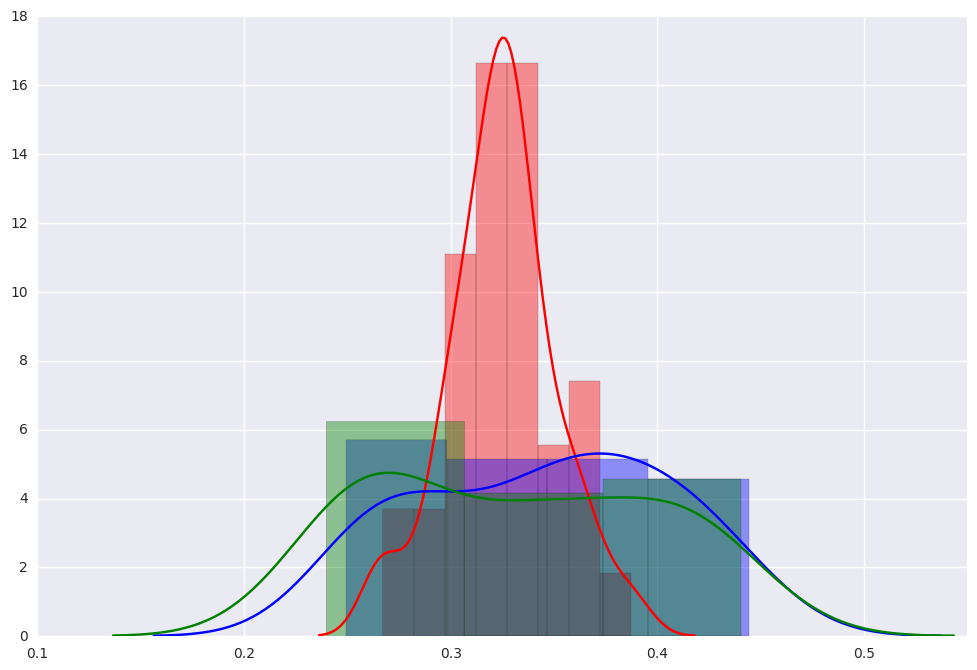

In [24]:
plt.figure(figsize=(12,8))
sns.distplot(y_test_hat_p[:,0], color='red')
sns.distplot(y_test_hat_p[:,1], color='blue')
sns.distplot(y_test_hat_p[:,2], color='green')

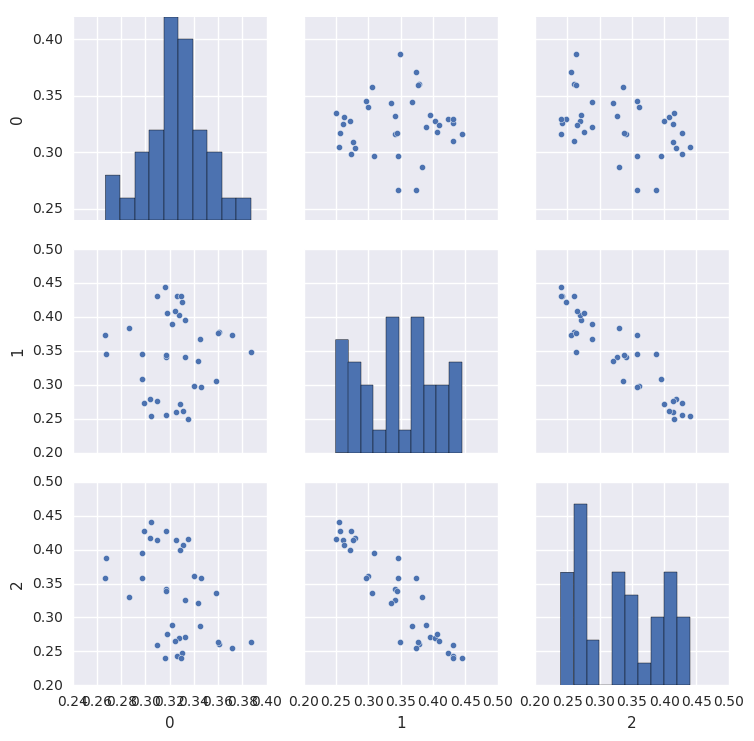

In [25]:
dfy = pd.DataFrame({'0': y_test_hat_p[:,0], '1': y_test_hat_p[:,1], '2': y_test_hat_p[:,2]})
sns.pairplot(dfy)

## Confusion matrix

The confusion matrix is a standard analysis tool in binary and multi-class classification where in each entry **C_{i,j}** corresponds to the number of samples that have true class label **i** and are predicted as **j**.

We can see that our models have a great problem with confusing class zero with class two.

In [26]:
from sklearn.metrics import confusion_matrix

y_test_hat = cv.predict(X_test)

data = [
    go.Heatmap(
        z=confusion_matrix(y_test, y_test_hat),
        x=[0, 1, 2],
        y=[0, 1, 2],
        colorscale='Viridis',
        text = True ,
        opacity = 1.0
    )
]

layout = go.Layout(
    title='Test Confusion matrix',
    xaxis = dict(ticks='', nticks=36),
    yaxis = dict(ticks='' ),
    width = 900, height = 700,
    
)


fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='labelled-heatmap')

## Confusion matrix on training set

Looking at the train confusion matrix, we can see that we almost only predict class 1.

In [27]:
from sklearn.metrics import confusion_matrix

y_train_hat = cv.predict(X_train)

data = [
    go.Heatmap(
        z=confusion_matrix(y_train, y_train_hat),
        x=[0, 1, 2],
        y=[0, 1, 2],
        colorscale='Viridis',
        text = True ,
        opacity = 1.0
    )
]

layout = go.Layout(
    title='Training Confusion matrix',
    xaxis = dict(ticks='', nticks=36),
    yaxis = dict(ticks='' ),
    width = 900, height = 700,
    
)


fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='labelled-heatmap')